# Prediction of ISUC scores using radiomic features from three different sequences

In [1]:
import os
import numpy as np
import sklearn
from tqdm import tqdm,trange

In [2]:
diagnost_keys = [
    'diagnostics_Versions_PyRadiomics', 'diagnostics_Versions_Numpy', 
    'diagnostics_Versions_SimpleITK', 'diagnostics_Versions_PyWavelet', 
    'diagnostics_Versions_Python', 'diagnostics_Image-original_Hash',
    'diagnostics_Image-original_Dimensionality',  
    'diagnostics_Mask-original_Hash', 'diagnostics_Mask-original_VoxelNum',
    'diagnostics_Mask-original_VolumeNum']

metadata_keys = [
    'path', 'lesion_id', 'sequence_id', 'class', 
    'config_file', 'registration', 'mask_resampling']

with open("radiomic_features/features_no_reg.csv", 'r') as o:
    header = next(o).strip().split(',')
    output_dict = {
        k:[] for k in header 
        if (k not in metadata_keys) and (k not in diagnost_keys)
        and (('original' in k) or ('wavelet' in k) or ('gradient' in k) or ('lbp' in k))}
    diagnost_dict = {k:[] for k in diagnost_keys}
    metadata_dict = {k:[] for k in metadata_keys}
    for line in o:
        line = line.strip().split(',')
        for i in range(len(line)):
            k = header[i]
            if k in output_dict:
                output_dict[k].append(float(line[i]))
            elif k in diagnost_keys:
                diagnost_dict[k].append(line[i])
            elif k in metadata_dict:
                metadata_dict[k].append(line[i])

metadata_dict["study_id"] = [
    '_'.join(x.split(os.sep)[-1].split('_')[:-1]) for x in metadata_dict['path']]

print(np.unique([x.split('_')[0] for x in output_dict.keys()]))

['diagnostics' 'gradient' 'lbp-2D' 'original' 'wavelet-HH' 'wavelet-HL'
 'wavelet-LH' 'wavelet-LL']


In [3]:
hierarchical_data = {}
for i in range(len(metadata_dict["study_id"])):
    study_id = metadata_dict["study_id"][i]
    lesion_id = int(float(metadata_dict["lesion_id"][i]))
    sequence_id = int(float(metadata_dict["sequence_id"][i]))
    cl = int(float(metadata_dict["class"][i]))
    data_row = []
    for k in output_dict:
        data_row.append(output_dict[k][i])
    data_row = np.array(data_row)
    if study_id not in hierarchical_data:
        hierarchical_data[study_id] = {}
    if lesion_id not in hierarchical_data[study_id]:
        hierarchical_data[study_id][lesion_id] = {}
    hierarchical_data[study_id][lesion_id][sequence_id] = {
        "data":data_row,"class":cl}

sequence_ids = [0,1,2]
data_dict = {k:[] for k in sequence_ids}
data_dict["class"] = []
for study_id in hierarchical_data:
    for lesion_id in hierarchical_data[study_id]:
        cur_s_ids = hierarchical_data[study_id][lesion_id].keys()
        # check that all sequences are available
        set_diff = set.difference(set(cur_s_ids),set(sequence_ids))
        if len(set_diff) == 0:
            for s in sequence_ids:
                v = hierarchical_data[study_id][lesion_id][s]["data"]
                cl = hierarchical_data[study_id][lesion_id][s]["class"]
                data_dict[s].append(v)
            data_dict["class"].append(cl)
for k in data_dict:
    data_dict[k] = np.array(data_dict[k])

## Setting up different steps

### Feature selection + standardization

In [4]:
class RemoveCorrelatedVariables:
    def __init__(self,threshold=0.8):
        self.threshold = threshold
    
    def fit(self,X,y=None):
        self.corr_coef = np.abs(np.corrcoef(X.T))
        self.var_to_remove = []
        for i in range(self.corr_coef.shape[0]):
            if i not in self.var_to_remove:
                high_coef = np.where(
                    self.corr_coef[i,:]>self.threshold)[0]
                high_coef = [x for x in high_coef if x != i]
                if len(high_coef) > 0:
                    # highest mean correlation
                    highest_mc = np.mean(self.corr_coef[i])
                    rm = []
                    for j in high_coef:
                        mc = np.mean(self.corr_coef[i])
                        if mc > highest_mc:
                            rm.append(j)
                    if len(rm) < len(high_coef):
                        self.var_to_remove.append(i)
                    else:
                        self.var_to_remove.extend(rm)
    
    def transform(self,X,y=None):
        return X[:,self.var_to_remove]
    
    def fit_transform(self,X,y=None):
        self.fit(X)
        return self.transform(X)

## Training

In [5]:
from sklearn.model_selection import StratifiedKFold,GridSearchCV
from sklearn.feature_selection import SelectFpr
from sklearn.utils import compute_sample_weight,compute_class_weight
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.linear_model import LogisticRegressionCV,SGDClassifier
from sklearn.neural_network import MLPClassifier,BernoulliRBM
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import LocalOutlierFactor
from sklearn.feature_selection import VarianceThreshold,SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler,RobustScaler
from sklearn.pipeline import Pipeline
import xgboost as xgb

def create_preprocessing_pipeline(C):
    return Pipeline([
        ('remove_nzv', VarianceThreshold()),
        ('remove_correlated_variables', RemoveCorrelatedVariables(0.95)),
        ('standardization',StandardScaler()),
        ('select_from_model', SelectFromModel(
            LinearSVC(
                penalty="l1",max_iter=50000,C=C,dual=False,
                class_weight="balanced",tol=1e-3)))
    ])

def binarize(x):
    return np.where(x <= 1,0,1)

model_dict_mc = {}
model_dict_binary = {}

skf = StratifiedKFold(5,random_state=42,shuffle=True)
cl = np.array(data_dict["class"]) - 2

model_id = "extra_trees"
model_params_dict = {
    "extra_trees":{
        "model":ExtraTreeClassifier,
        "params":{"class_weight":"balanced"},
        "cv_params":{'splitter':('random','best'),
                     'min_samples_split':(2,4)} 
    },
    "elastic":{
        "model":SGDClassifier,
        "params":{"penalty":"elasticnet",
                  "n_jobs":1,
                  "class_weight":"balanced",
                  "loss":"modified_huber"},
        "cv_params":{"alpha":[0.001,0.01,0.1,0.5]}
    },
    "l2":{
        "model":LogisticRegressionCV,
        "params":{"penalty":"l2",
                  "max_iter":1000,
                  "class_weight":"balanced",
                  "n_jobs":1},
        "cv_params":{"Cs":[10,20,30]}
    },
    "mlp":{
        "model":MLPClassifier,
        "params":{"max_iter":1000},
        "cv_params":{"alpha":[0.01,0.1,0.5,1],
                     "hidden_layer_sizes":[(100,),(100,100,),(100,100,100)]}
    },
    "knn":{
        "model":KNeighborsClassifier,
        "params":{},
        "cv_params":{"n_neighbors":[5,7,10],
                     "weights":["uniform","distance"]}
    },
    "rf":{
        "model":RandomForestClassifier,
        "params":{"oob_score":False,"class_weight":"balanced"},
        "cv_params":{"n_estimators":[25,50]}
    },
    "grad_boost":{
        "model":GradientBoostingClassifier,
        "params":{"subsample":0.5},
        "cv_params":{"n_estimators":[25,50]}
    }
}

In [6]:
models_to_train = [
    "grad_boost",
    "rf",
    "knn",
    "mlp",
    "extra_trees",
    "elastic",
    "l2"
]

C_preproc = 0.5
remove_outliers = False

for model_id in models_to_train:
    model_params = model_params_dict[model_id]
    cv_params = model_params["cv_params"]
    classifier_fn = model_params["model"]
    classifier_params = model_params["params"]

    model_dict_mc[model_id] = {}
    model_dict_binary[model_id] = {}

    for comb in [[0],[1],[2],[0,1],[0,2],[1,2],[0,1,2]]:
        data = np.concatenate(
            [data_dict[i] for i in comb],axis=1)

        cr_key = ':'.join([["T2W","ADC","HBV"][i] for i in comb])
        model_dict_mc[model_id][cr_key] = []
        model_dict_binary[model_id][cr_key] = []
        splits = skf.split([i for i in range(len(cl))],cl)
        for i,(train_split,val_split) in enumerate(splits):
            print(model_id,cr_key,"fold =",i)
            preproc_pipeline = create_preprocessing_pipeline(C_preproc)
            # data
            training_set_original = data[train_split,:]
            val_set_original = data[val_split,:]

            # class
            training_y = cl[train_split]
            val_y = cl[val_split]
            training_y_binary = binarize(training_y)
            val_y_binary = binarize(val_y)

            preproc_pipeline.fit(training_set_original,training_y)
            training_set = preproc_pipeline.transform(training_set_original)
            val_set = preproc_pipeline.transform(val_set_original)
            
            if remove_outliers == True:
                rm_outliers = LocalOutlierFactor(novelty=True)
                rm_outliers.fit(training_set)
                inliers = rm_outliers.predict(training_set)
                inliers = np.where(inliers < 0,False,True)
                training_set = training_set[inliers,:]
                training_y = training_y[inliers]
            else:
                inliers = []

            classifier = GridSearchCV(
                classifier_fn(**classifier_params),cv_params,n_jobs=8,
                scoring="f1_macro")

            classifier.fit(training_set,training_y)

            training_pred = classifier.predict(training_set)
            training_prob = classifier.predict_proba(training_set)
            
            val_pred = classifier.predict(val_set)
            val_prob = classifier.predict_proba(val_set)
            
            model_dict_mc[model_id][cr_key].append(
                {"classification_report_train":classification_report(
                    training_y,training_pred,output_dict=True,zero_division=0),
                 "classification_report_val":classification_report(
                     val_y,val_pred,output_dict=True,zero_division=0),
                 "auc_train":roc_auc_score(training_y,training_prob,
                                           multi_class='ovo'),
                 "auc_val":roc_auc_score(val_y,val_prob,
                                         multi_class='ovo'),
                 "model":classifier,
                 "preproc_pipeline":preproc_pipeline,
                 "train_split":train_split,
                 "val_split":val_split,
                 "inliers":inliers})
            
            preproc_pipeline = create_preprocessing_pipeline(C_preproc)
            preproc_pipeline.fit(training_set_original,training_y_binary)
            training_set = preproc_pipeline.transform(training_set_original)
            val_set = preproc_pipeline.transform(val_set_original)
            
            if remove_outliers == True:
                rm_outliers.fit(training_set)
                inliers = rm_outliers.predict(training_set)
                inliers = np.where(inliers < 0,False,True)
                training_set = training_set[inliers,:]
                training_y_binary = training_y_binary[inliers]
            else:
                inliers = []

            classifier = GridSearchCV(
                classifier_fn(**classifier_params),cv_params,n_jobs=8,
                scoring="f1_macro")

            classifier.fit(training_set,training_y_binary)

            training_pred = classifier.predict(training_set)
            training_prob = classifier.predict_proba(training_set)
            try: training_prob = training_prob[:,1]
            except: pass

            val_pred = classifier.predict(val_set)
            val_prob = classifier.predict_proba(val_set)
            try: val_prob = val_prob[:,1]
            except: pass

            model_dict_binary[model_id][cr_key].append(
                {"classification_report_train":classification_report(
                    training_y_binary,training_pred,output_dict=True,zero_division=0),
                 "classification_report_val":classification_report(
                     val_y_binary,val_pred,output_dict=True,zero_division=0),
                 "auc_train":roc_auc_score(training_y_binary,training_prob),
                 "auc_val":roc_auc_score(val_y_binary,val_prob),
                 "model":classifier,
                 "preproc_pipeline":preproc_pipeline,
                 "train_split":train_split,
                 "val_split":val_split,
                 "inliers":inliers})

grad_boost T2W fold = 0
grad_boost T2W fold = 1
grad_boost T2W fold = 2
grad_boost T2W fold = 3
grad_boost T2W fold = 4
grad_boost ADC fold = 0
grad_boost ADC fold = 1
grad_boost ADC fold = 2
grad_boost ADC fold = 3
grad_boost ADC fold = 4
grad_boost HBV fold = 0
grad_boost HBV fold = 1
grad_boost HBV fold = 2
grad_boost HBV fold = 3
grad_boost HBV fold = 4
grad_boost T2W:ADC fold = 0
grad_boost T2W:ADC fold = 1
grad_boost T2W:ADC fold = 2
grad_boost T2W:ADC fold = 3
grad_boost T2W:ADC fold = 4
grad_boost T2W:HBV fold = 0
grad_boost T2W:HBV fold = 1
grad_boost T2W:HBV fold = 2
grad_boost T2W:HBV fold = 3
grad_boost T2W:HBV fold = 4
grad_boost ADC:HBV fold = 0
grad_boost ADC:HBV fold = 1
grad_boost ADC:HBV fold = 2
grad_boost ADC:HBV fold = 3
grad_boost ADC:HBV fold = 4
grad_boost T2W:ADC:HBV fold = 0
grad_boost T2W:ADC:HBV fold = 1
grad_boost T2W:ADC:HBV fold = 2
grad_boost T2W:ADC:HBV fold = 3
grad_boost T2W:ADC:HBV fold = 4
rf T2W fold = 0
rf T2W fold = 1
rf T2W fold = 2
rf T2W fold 

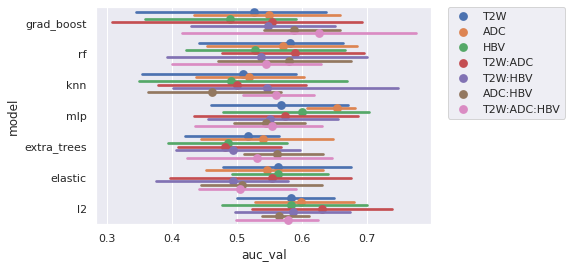

In [45]:
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd

ks = ["f1-score","recall","precision","auc"]
metric_dict = {"model":[],"mods":[],"fold":[]}
for k in ks:
    metric_dict[k+"_val"] = []
    metric_dict[k+"_train"] = []
    
for model_id in model_dict_binary:
    for k in model_dict_binary[model_id]:
        cr = model_dict_binary[model_id][k]
        for i,c in enumerate(cr):
            cr_train = c["classification_report_train"]["1"]
            cr_val = c["classification_report_val"]["1"]
            metric_dict["auc_train"].append(c["auc_train"])
            metric_dict["auc_val"].append(c["auc_val"])
            metric_dict["model"].append(model_id)
            metric_dict["mods"].append(k)
            metric_dict["fold"].append(i)
            for metric_k in cr_train:
                if metric_k in ks:
                    metric_dict[metric_k+"_train"].append(cr_train[metric_k])
            for metric_k in cr_val:
                if metric_k in ks:
                    metric_dict[metric_k+"_val"].append(cr_val[metric_k])

binary_metrics_df = pd.DataFrame(metric_dict)

sb.set(style="darkgrid")

sb.pointplot(
    data=binary_metrics_df,
    x="auc_val",y="model",hue="mods",join=False,dodge=0.7,
    size=0.05,ci=100)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)